# ETL Movies:

## Propuesta de trabajo (requerimientos de aprobación)
Transformaciones: Para este MVP no necesitas perfección, ¡necesitas rapidez! ⏩ Vas a hacer estas, y solo estas, transformaciones a los datos:

* 1 Algunos campos, como belongs_to_collection, production_companies y otros (ver diccionario de datos) están anidados, esto es o bien tienen un diccionario o una lista como valores en cada fila, ¡deberán desanidarlos para poder y unirlos al dataset de nuevo hacer alguna de las consultas de la API! O bien buscar la manera de acceder a esos datos sin desanidarlos.

* 2 Los valores nulos de los campos revenue, budget deben ser rellenados por el número 0.

* 3 Los valores nulos del campo release date deben eliminarse.

* 4 De haber fechas, deberán tener el formato AAAA-mm-dd, además deberán crear la columna release_year donde extraerán el año de la fecha de estreno.

* 5 Crear la columna con el retorno de inversión, llamada return con los campos revenue y budget, dividiendo estas dos últimas revenue / budget, cuando no hay datos disponibles para calcularlo, deberá tomar el valor 0.

* 6 Eliminar las columnas que no serán utilizadas, video,imdb_id,adult,original_title,poster_path y homepage.

## Librerias necesarias:

In [92]:
import pandas as pd
import ast
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

## Ingesta de Datasets:

In [93]:
csvs_to_read = [1, 2, 3]
dfs = []
encodings = ['ANSI', 'ANSI', 'UTF-8']

for i, number in enumerate(csvs_to_read):
    df = pd.read_csv(f'D:\Data Scientist\CURSADO HENRY DTS09\PI\PI1_PT02\PI_ML_OPS_PT02\Datasets\Movies_datasets\CSVs Movies\movies_dataset_{number}.csv', encoding=encodings[i], sep=',',low_memory=False)
    dfs.append(df)

# Concatenar todos los DataFrames en uno solo
df_movies = pd.concat(dfs, ignore_index=True)

# Ahora df_movies contiene todos los datos de los tres CSVs en un solo DataFrame

In [94]:
df_movies.shape

(136398, 24)

In [95]:
df_movies.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,FALSO,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,FALSO,7.7,5415.0
1,FALSO,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,FALSO,6.9,2413.0
2,FALSO,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,FALSO,6.5,92.0
3,FALSO,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,FALSO,6.1,34.0
4,FALSO,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,FALSO,5.7,173.0


## * 6 Eliminar las columnas que no serán utilizadas, video,imdb_id,adult,original_title,poster_path y homepage.

In [96]:
# Suponiendo que ya tienes el DataFrame df_movies cargado o creado

# Lista de columnas a eliminar
columnas_a_eliminar = ['video', 'imdb_id', 'adult', 'original_title', 'poster_path', 'homepage','belongs_to_collection', 'tagline']

# Utilizamos el método drop() para eliminar las columnas
df_movies = df_movies.drop(columnas_a_eliminar, axis=1)

# Si quieres aplicar los cambios directamente en el DataFrame original sin crear una copia, puedes usar el argumento inplace=True
# df_movies.drop(columnas_a_eliminar, axis=1, inplace=True)


In [97]:
df_movies.isnull().sum()

budget                     0
genres                     0
id                         0
original_language         33
overview                2872
popularity                15
production_companies       9
production_countries       9
release_date             261
revenue                   18
runtime                  789
spoken_languages          18
status                   261
title                     18
vote_average              18
vote_count                18
dtype: int64

<Axes: >

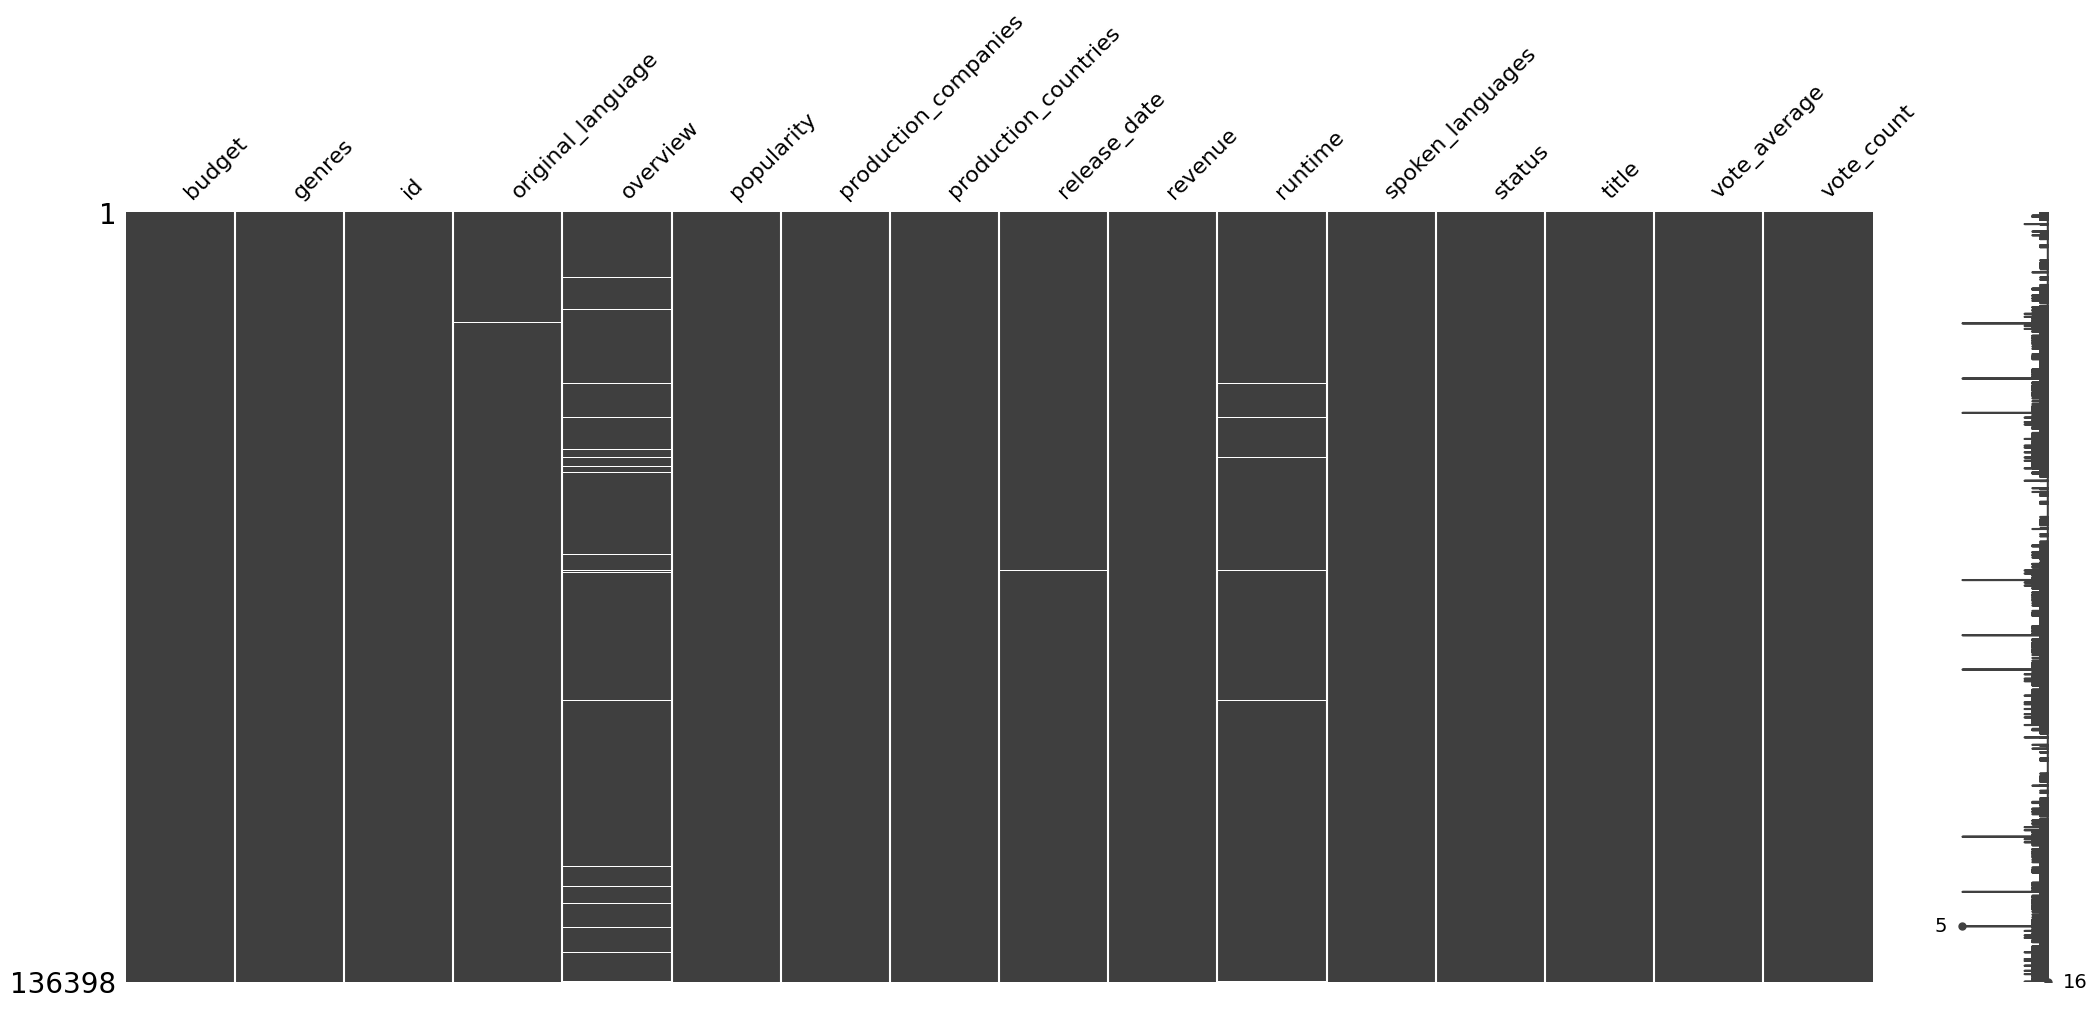

In [98]:
msno.matrix(df_movies)

## Desarmando los diccionarios dentro..

### Genres col:

In [99]:
import json
from collections import Counter
import ast
import ast # Módulo para analizar cadenas como literales de Python (necesario para convertir la cadena del diccionario a un diccionario real)

dict_cols = ['genres']

columns_to_separate = pd.DataFrame(df_movies['genres'])
columns_to_separate

,genres
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,"[{'id': 35, 'name': 'Comedy'}]"
...,...
136393,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n..."
136394,"[{'id': 18, 'name': 'Drama'}]"
136395,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam..."
136396,[]


In [100]:
# Convertimos la cadena de diccionario a un diccionario real usando ast.literal_eval
columns_to_separate['genres'] = columns_to_separate['genres'].apply(lambda x: ast.literal_eval(x))

# Creamos listas para almacenar los IDs y nombres de género
genre_ids_list = []
genre_names_list = []

# Iteramos a través del DataFrame y extraemos los IDs y nombres de género
for genres_list in columns_to_separate['genres']:
    ids = [genre['id'] for genre in genres_list]
    names = [genre['name'] for genre in genres_list]
    genre_ids_list.append(ids)
    genre_names_list.append(names)

# Creamos un nuevo DataFrame con las listas creadas
new_df = pd.DataFrame({'genre_ids': genre_ids_list, 'genre_names': genre_names_list})

# Unimos los IDs y nombres de género en una sola cadena separada por comas
df_movies['genre_ids'] = new_df['genre_ids'].apply(lambda x: ', '.join(map(str, x)))
df_movies['genre_names'] = new_df['genre_names'].apply(lambda x: ', '.join(x))

print(df_movies.head(10))


     budget                                             genres     id  \
0  30000000  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...    862   
1  65000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   8844   
2         0  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...  15602   
3  16000000  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  31357   
4         0                     [{'id': 35, 'name': 'Comedy'}]  11862   
5  60000000  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...    949   
6  58000000  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...  11860   
7         0  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...  45325   
8  35000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   9091   
9  58000000  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...    710   

  original_language                                           overview  \
0                en  Led by Woody, Andy's toys live happily in his ...   
1                en  When siblings Judy and Pete

In [101]:
df_movies = df_movies.drop('genres', axis=1)

In [102]:
df_movies

,budget,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,genre_ids,genre_names
0,30000000,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,7.7,5415.0,"16, 35, 10751","Animation, Comedy, Family"
1,65000000,8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,6.9,2413.0,"12, 14, 10751","Adventure, Fantasy, Family"
2,0,15602,en,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,6.5,92.0,"10749, 35","Romance, Comedy"
3,16000000,31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,6.1,34.0,"35, 18, 10749","Comedy, Drama, Romance"
4,0,11862,en,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,5.7,173.0,35,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136393,0,439050,fa,Rising and falling between a man and woman.,0.072051,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Subdue,4.0,1.0,"18, 10751","Drama, Family"
136394,0,111109,tl,An artist struggles to finish his work while a...,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,Century of Birthing,9.0,3.0,18,Drama
136395,0,67758,en,"When one of her hits goes wrong, a professiona...",0.903007,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Betrayal,3.8,6.0,"28, 18, 53","Action, Drama, Thriller"
136396,0,227506,en,"In a small town live two brothers, one a minis...",0.003503,"[{'name': 'Yermoliev', 'id': 88753}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1917-10-21,0.0,87.0,[],Released,Satan Triumphant,0.0,0.0,,


In [103]:
#_______________________________________________________________________

### Production_companies col:

In [104]:
dict_cols = ['production_companies']

columns_to_separate = pd.DataFrame(df_movies['production_companies'])
columns_to_separate

,production_companies
0,"[{'name': 'Pixar Animation Studios', 'id': 3}]"
1,"[{'name': 'TriStar Pictures', 'id': 559}, {'na..."
2,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'..."
3,[{'name': 'Twentieth Century Fox Film Corporat...
4,"[{'name': 'Sandollar Productions', 'id': 5842}..."
...,...
136393,[]
136394,"[{'name': 'Sine Olivia', 'id': 19653}]"
136395,"[{'name': 'American World Pictures', 'id': 6165}]"
136396,"[{'name': 'Yermoliev', 'id': 88753}]"


In [105]:
# Paso 1: Manejar los valores 'NaN' en la columna 'production_companies'
df_movies['production_companies'] = df_movies['production_companies'].fillna('[]')

# Paso 2: Convertir la cadena de diccionario a un diccionario real usando ast.literal_eval
def parse_production_companies(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

df_movies['production_companies'] = df_movies['production_companies'].apply(parse_production_companies)

# Paso 3: Extraer la información del diccionario y crear dos nuevas listas
ids_list = []
names_list = []

for row in df_movies['production_companies']:
    if isinstance(row, list) and len(row) > 0:  # Verificar que haya una lista válida en la fila
        ids = []
        names = []
        for entry in row:
            if 'id' in entry and 'name' in entry:
                ids.append(str(entry['id']))
                names.append(entry['name'])
        ids_list.append(','.join(ids))
        names_list.append(','.join(names))
    else:
        ids_list.append('NaN')  # O cualquier otro valor predeterminado para indicar datos faltantes
        names_list.append('NaN')

# Paso 4: Crear un nuevo DataFrame con los valores separados por comas en las columnas
df_new = pd.DataFrame({'production_companies_ids': ids_list, 'production_companies_nombres': names_list})

# Unimos los IDs y nombres de género en una sola cadena separada por comas
df_movies['production_companies_ids'] = df_new['production_companies_ids']
df_movies['production_companies_nombres'] = df_new['production_companies_nombres']

print(df_movies.head(10))
# Ver el resultado
print(df_new)


     budget     id original_language  \
0  30000000    862                en   
1  65000000   8844                en   
2         0  15602                en   
3  16000000  31357                en   
4         0  11862                en   
5  60000000    949                en   
6  58000000  11860                en   
7         0  45325                en   
8  35000000   9091                en   
9  58000000    710                en   

                                            overview popularity  \
0  Led by Woody, Andy's toys live happily in his ...  21.946943   
1  When siblings Judy and Peter discover an encha...  17.015539   
2  A family wedding reignites the ancient feud be...    11.7129   
3  Cheated on, mistreated and stepped on, the wom...   3.859495   
4  Just when George Banks has recovered from his ...   8.387519   
5  Obsessive master thief, Neil McCauley leads a ...  17.924927   
6  An ugly duckling having undergone a remarkable...   6.677277   
7  A mischievous young 

In [106]:
df_movies = df_movies.drop('production_companies', axis=1)

In [107]:
df_movies

,budget,id,original_language,overview,popularity,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,genre_ids,genre_names,production_companies_ids,production_companies_nombres
0,30000000,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,7.7,5415.0,"16, 35, 10751","Animation, Comedy, Family",3,Pixar Animation Studios
1,65000000,8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,6.9,2413.0,"12, 14, 10751","Adventure, Fantasy, Family","559,2550,10201","TriStar Pictures,Teitler Film,Interscope Commu..."
2,0,15602,en,A family wedding reignites the ancient feud be...,11.7129,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,6.5,92.0,"10749, 35","Romance, Comedy","6194,19464","Warner Bros.,Lancaster Gate"
3,16000000,31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,6.1,34.0,"35, 18, 10749","Comedy, Drama, Romance",306,Twentieth Century Fox Film Corporation
4,0,11862,en,Just when George Banks has recovered from his ...,8.387519,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,5.7,173.0,35,Comedy,"5842,9195","Sandollar Productions,Touchstone Pictures"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136393,0,439050,fa,Rising and falling between a man and woman.,0.072051,"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Subdue,4.0,1.0,"18, 10751","Drama, Family",NaN,NaN
136394,0,111109,tl,An artist struggles to finish his work while a...,0.178241,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,Century of Birthing,9.0,3.0,18,Drama,19653,Sine Olivia
136395,0,67758,en,"When one of her hits goes wrong, a professiona...",0.903007,"[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Betrayal,3.8,6.0,"28, 18, 53","Action, Drama, Thriller",6165,American World Pictures
136396,0,227506,en,"In a small town live two brothers, one a minis...",0.003503,"[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1917-10-21,0.0,87.0,[],Released,Satan Triumphant,0.0,0.0,,,88753,Yermoliev


In [108]:
#_______________________________________________________________________

### Production_countries col:

In [109]:
dict_cols = ['production_countries']

columns_to_separate = pd.DataFrame(df_movies['production_countries'])
columns_to_separate

,production_countries
0,"[{'iso_3166_1': 'US', 'name': 'United States o..."
1,"[{'iso_3166_1': 'US', 'name': 'United States o..."
2,"[{'iso_3166_1': 'US', 'name': 'United States o..."
3,"[{'iso_3166_1': 'US', 'name': 'United States o..."
4,"[{'iso_3166_1': 'US', 'name': 'United States o..."
...,...
136393,"[{'iso_3166_1': 'IR', 'name': 'Iran'}]"
136394,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]"
136395,"[{'iso_3166_1': 'US', 'name': 'United States o..."
136396,"[{'iso_3166_1': 'RU', 'name': 'Russia'}]"


In [110]:
# Paso 1: Manejar los valores 'NaN' en la columna 'production_countries'
df_movies['production_countries'] = df_movies['production_countries'].fillna('[]')

# Paso 2: Convertir la cadena de diccionario a un diccionario real usando ast.literal_eval
def parse_production_countries(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

df_movies['production_countries'] = df_movies['production_countries'].apply(parse_production_countries)

# Paso 3: Extraer la información del diccionario y crear dos nuevas listas
iso_list = []
names_list = []

for row in df_movies['production_countries']:
    if isinstance(row, list) and len(row) > 0:  # Verificar que haya una lista válida en la fila
        isos = []
        names = []
        for entry in row:
            if 'iso_3166_1' in entry and 'name' in entry:
                isos.append(entry['iso_3166_1'])
                names.append(entry['name'])
        iso_list.append(','.join(isos))
        names_list.append(','.join(names))
    else:
        iso_list.append('NaN')  # O cualquier otro valor predeterminado para indicar datos faltantes
        names_list.append('NaN')

# Paso 4: Crear un nuevo DataFrame con los valores separados por comas en las columnas
df_new = pd.DataFrame({'iso_codes': iso_list, 'country_names': names_list})

# Unimos los códigos ISO y nombres de país en una sola cadena separada por comas
df_movies['iso_codes'] = df_new['iso_codes']
df_movies['country_names'] = df_new['country_names']

# Imprimimos el resultado
print(df_movies.head(10))


     budget     id original_language  \
0  30000000    862                en   
1  65000000   8844                en   
2         0  15602                en   
3  16000000  31357                en   
4         0  11862                en   
5  60000000    949                en   
6  58000000  11860                en   
7         0  45325                en   
8  35000000   9091                en   
9  58000000    710                en   

                                            overview popularity  \
0  Led by Woody, Andy's toys live happily in his ...  21.946943   
1  When siblings Judy and Peter discover an encha...  17.015539   
2  A family wedding reignites the ancient feud be...    11.7129   
3  Cheated on, mistreated and stepped on, the wom...   3.859495   
4  Just when George Banks has recovered from his ...   8.387519   
5  Obsessive master thief, Neil McCauley leads a ...  17.924927   
6  An ugly duckling having undergone a remarkable...   6.677277   
7  A mischievous young 

In [111]:
df_movies = df_movies.drop('production_countries', axis=1)

In [112]:
df_movies['country_names'].head(30)

0                          United States of America
1                          United States of America
2                          United States of America
3                          United States of America
4                          United States of America
5                          United States of America
6                  Germany,United States of America
7                          United States of America
8                          United States of America
9           United Kingdom,United States of America
10                         United States of America
11                  France,United States of America
12                         United States of America
13                         United States of America
14    France,Germany,Italy,United States of America
15                  France,United States of America
16          United Kingdom,United States of America
17                         United States of America
18                         United States of America
19          

In [113]:
#___________________________________________________________________

### Spoken_lenguages col:

In [114]:
dict_cols = ['spoken_languages']

columns_to_separate = pd.DataFrame(df_movies['spoken_languages'])
columns_to_separate

,spoken_languages
0,"[{'iso_639_1': 'en', 'name': 'English'}]"
1,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso..."
2,"[{'iso_639_1': 'en', 'name': 'English'}]"
3,"[{'iso_639_1': 'en', 'name': 'English'}]"
4,"[{'iso_639_1': 'en', 'name': 'English'}]"
...,...
136393,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]"
136394,"[{'iso_639_1': 'tl', 'name': ''}]"
136395,"[{'iso_639_1': 'en', 'name': 'English'}]"
136396,[]


In [115]:
# Paso 1: Manejar los valores 'NaN' en la columna 'spoken_languages'
df_movies['spoken_languages'] = df_movies['spoken_languages'].fillna('[]')

# Paso 2: Convertir la cadena de diccionario a un diccionario real usando ast.literal_eval
def parse_spoken_languages(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

df_movies['spoken_languages'] = df_movies['spoken_languages'].apply(parse_spoken_languages)

# Paso 3: Extraer la información del diccionario y crear dos nuevas listas
iso_list = []
language_names_list = []

for row in df_movies['spoken_languages']:
    if isinstance(row, list) and len(row) > 0:  # Verificar que haya una lista válida en la fila
        isos = []
        language_names = []
        for entry in row:
            if 'iso_639_1' in entry and 'name' in entry:
                isos.append(entry['iso_639_1'])
                language_names.append(entry['name'])
        iso_list.append(','.join(isos))
        language_names_list.append(','.join(language_names))
    else:
        iso_list.append('NaN')  # O cualquier otro valor predeterminado para indicar datos faltantes
        language_names_list.append('NaN')

# Paso 4: Crear un nuevo DataFrame con los valores separados por comas en las columnas
df_new = pd.DataFrame({'iso_language_codes': iso_list, 'language_names': language_names_list})

# Unimos los códigos ISO y nombres de idioma en una sola cadena separada por comas
df_movies['iso_language_codes'] = df_new['iso_language_codes']
df_movies['language_names'] = df_new['language_names']

# Imprimimos el resultado
print(df_movies.head(10))


     budget     id original_language  \
0  30000000    862                en   
1  65000000   8844                en   
2         0  15602                en   
3  16000000  31357                en   
4         0  11862                en   
5  60000000    949                en   
6  58000000  11860                en   
7         0  45325                en   
8  35000000   9091                en   
9  58000000    710                en   

                                            overview popularity release_date  \
0  Led by Woody, Andy's toys live happily in his ...  21.946943   1995-10-30   
1  When siblings Judy and Peter discover an encha...  17.015539   1995-12-15   
2  A family wedding reignites the ancient feud be...    11.7129   1995-12-22   
3  Cheated on, mistreated and stepped on, the wom...   3.859495   1995-12-22   
4  Just when George Banks has recovered from his ...   8.387519   1995-02-10   
5  Obsessive master thief, Neil McCauley leads a ...  17.924927   1995-12-15   

In [116]:
df_movies = df_movies.drop('spoken_languages', axis=1)

In [117]:
df_movies[['iso_language_codes','language_names']].head(10)

,iso_language_codes,language_names
0,en,English
1,"en,fr","English,Français"
2,en,English
3,en,English
4,en,English
5,"en,es","English,Español"
6,"fr,en","Français,English"
7,"en,de","English,Deutsch"
8,en,English
9,"en,ru,es","English,P??????,Español"


In [118]:
df_movies.head()

,budget,id,original_language,overview,popularity,release_date,revenue,runtime,status,title,vote_average,vote_count,genre_ids,genre_names,production_companies_ids,production_companies_nombres,iso_codes,country_names,iso_language_codes,language_names
0,30000000,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,81.0,Released,Toy Story,7.7,5415.0,"16, 35, 10751","Animation, Comedy, Family",3,Pixar Animation Studios,US,United States of America,en,English
1,65000000,8844,en,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,262797249.0,104.0,Released,Jumanji,6.9,2413.0,"12, 14, 10751","Adventure, Fantasy, Family","559,2550,10201","TriStar Pictures,Teitler Film,Interscope Commu...",US,United States of America,"en,fr","English,Français"
2,0,15602,en,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,0.0,101.0,Released,Grumpier Old Men,6.5,92.0,"10749, 35","Romance, Comedy","6194,19464","Warner Bros.,Lancaster Gate",US,United States of America,en,English
3,16000000,31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,1995-12-22,81452156.0,127.0,Released,Waiting to Exhale,6.1,34.0,"35, 18, 10749","Comedy, Drama, Romance",306,Twentieth Century Fox Film Corporation,US,United States of America,en,English
4,0,11862,en,Just when George Banks has recovered from his ...,8.387519,1995-02-10,76578911.0,106.0,Released,Father of the Bride Part II,5.7,173.0,35,Comedy,"5842,9195","Sandollar Productions,Touchstone Pictures",US,United States of America,en,English


#### Explorando un poco mas los Spoken languages:

In [119]:
listado_df = pd.DataFrame({
    'iso_language_codes': df_movies['iso_language_codes'],
    'language_names': df_movies['language_names']
})


In [120]:
listado_df.head()

,iso_language_codes,language_names
0,en,English
1,"en,fr","English,Français"
2,en,English
3,en,English
4,en,English


In [121]:
# Dividir los valores separados por comas en nuevas filas
listado_df['iso_language_codes'] = listado_df['iso_language_codes'].str.split(',')
listado_df['language_names'] = listado_df['language_names'].str.split(',')

# Crear una nueva columna para contar las repeticiones
listado_df['count'] = 1

# Agrupar por los valores únicos en 'iso_language_codes' y 'language_names' y sumar los conteos
result = listado_df.explode('iso_language_codes').explode('language_names').groupby(['iso_language_codes', 'language_names'], as_index=False)['count'].sum()

# Ordenar por la columna 'count' de manera descendente
result = result.sort_values(by='count', ascending=False)

# Mostrar los resultados
print(result)

     iso_language_codes  language_names  count
520                  en         English  86235
784                  fr        Français  12588
0                   NaN             NaN  11505
397                  de         Deutsch   7875
606                  es         Español   7239
...                 ...             ...    ...
1324                 ku        ελληνικά      1
1363                 la           Český      1
1365                 la  български език      1
1368                 la          हिन्दी      1
2538                 zu          हिन्दी      1

[2539 rows x 3 columns]


In [122]:
result.tail(5)

,iso_language_codes,language_names,count
1324,ku,ελληνικά,1
1363,la,Český,1
1365,la,български език,1
1368,la,हिन्दी,1
2538,zu,हिन्दी,1


## Continue with cleaning:

In [123]:
df_movies

,budget,id,original_language,overview,popularity,release_date,revenue,runtime,status,title,vote_average,vote_count,genre_ids,genre_names,production_companies_ids,production_companies_nombres,iso_codes,country_names,iso_language_codes,language_names
0,30000000,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,81.0,Released,Toy Story,7.7,5415.0,"16, 35, 10751","Animation, Comedy, Family",3,Pixar Animation Studios,US,United States of America,en,English
1,65000000,8844,en,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,262797249.0,104.0,Released,Jumanji,6.9,2413.0,"12, 14, 10751","Adventure, Fantasy, Family","559,2550,10201","TriStar Pictures,Teitler Film,Interscope Commu...",US,United States of America,"en,fr","English,Français"
2,0,15602,en,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,0.0,101.0,Released,Grumpier Old Men,6.5,92.0,"10749, 35","Romance, Comedy","6194,19464","Warner Bros.,Lancaster Gate",US,United States of America,en,English
3,16000000,31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,1995-12-22,81452156.0,127.0,Released,Waiting to Exhale,6.1,34.0,"35, 18, 10749","Comedy, Drama, Romance",306,Twentieth Century Fox Film Corporation,US,United States of America,en,English
4,0,11862,en,Just when George Banks has recovered from his ...,8.387519,1995-02-10,76578911.0,106.0,Released,Father of the Bride Part II,5.7,173.0,35,Comedy,"5842,9195","Sandollar Productions,Touchstone Pictures",US,United States of America,en,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136393,0,439050,fa,Rising and falling between a man and woman.,0.072051,NaN,0.0,90.0,Released,Subdue,4.0,1.0,"18, 10751","Drama, Family",NaN,NaN,IR,Iran,fa,فارسی
136394,0,111109,tl,An artist struggles to finish his work while a...,0.178241,2011-11-17,0.0,360.0,Released,Century of Birthing,9.0,3.0,18,Drama,19653,Sine Olivia,PH,Philippines,tl,
136395,0,67758,en,"When one of her hits goes wrong, a professiona...",0.903007,2003-08-01,0.0,90.0,Released,Betrayal,3.8,6.0,"28, 18, 53","Action, Drama, Thriller",6165,American World Pictures,US,United States of America,en,English
136396,0,227506,en,"In a small town live two brothers, one a minis...",0.003503,1917-10-21,0.0,87.0,Released,Satan Triumphant,0.0,0.0,,,88753,Yermoliev,RU,Russia,NaN,NaN


In [124]:
df_movies = df_movies.drop_duplicates()

<Axes: >

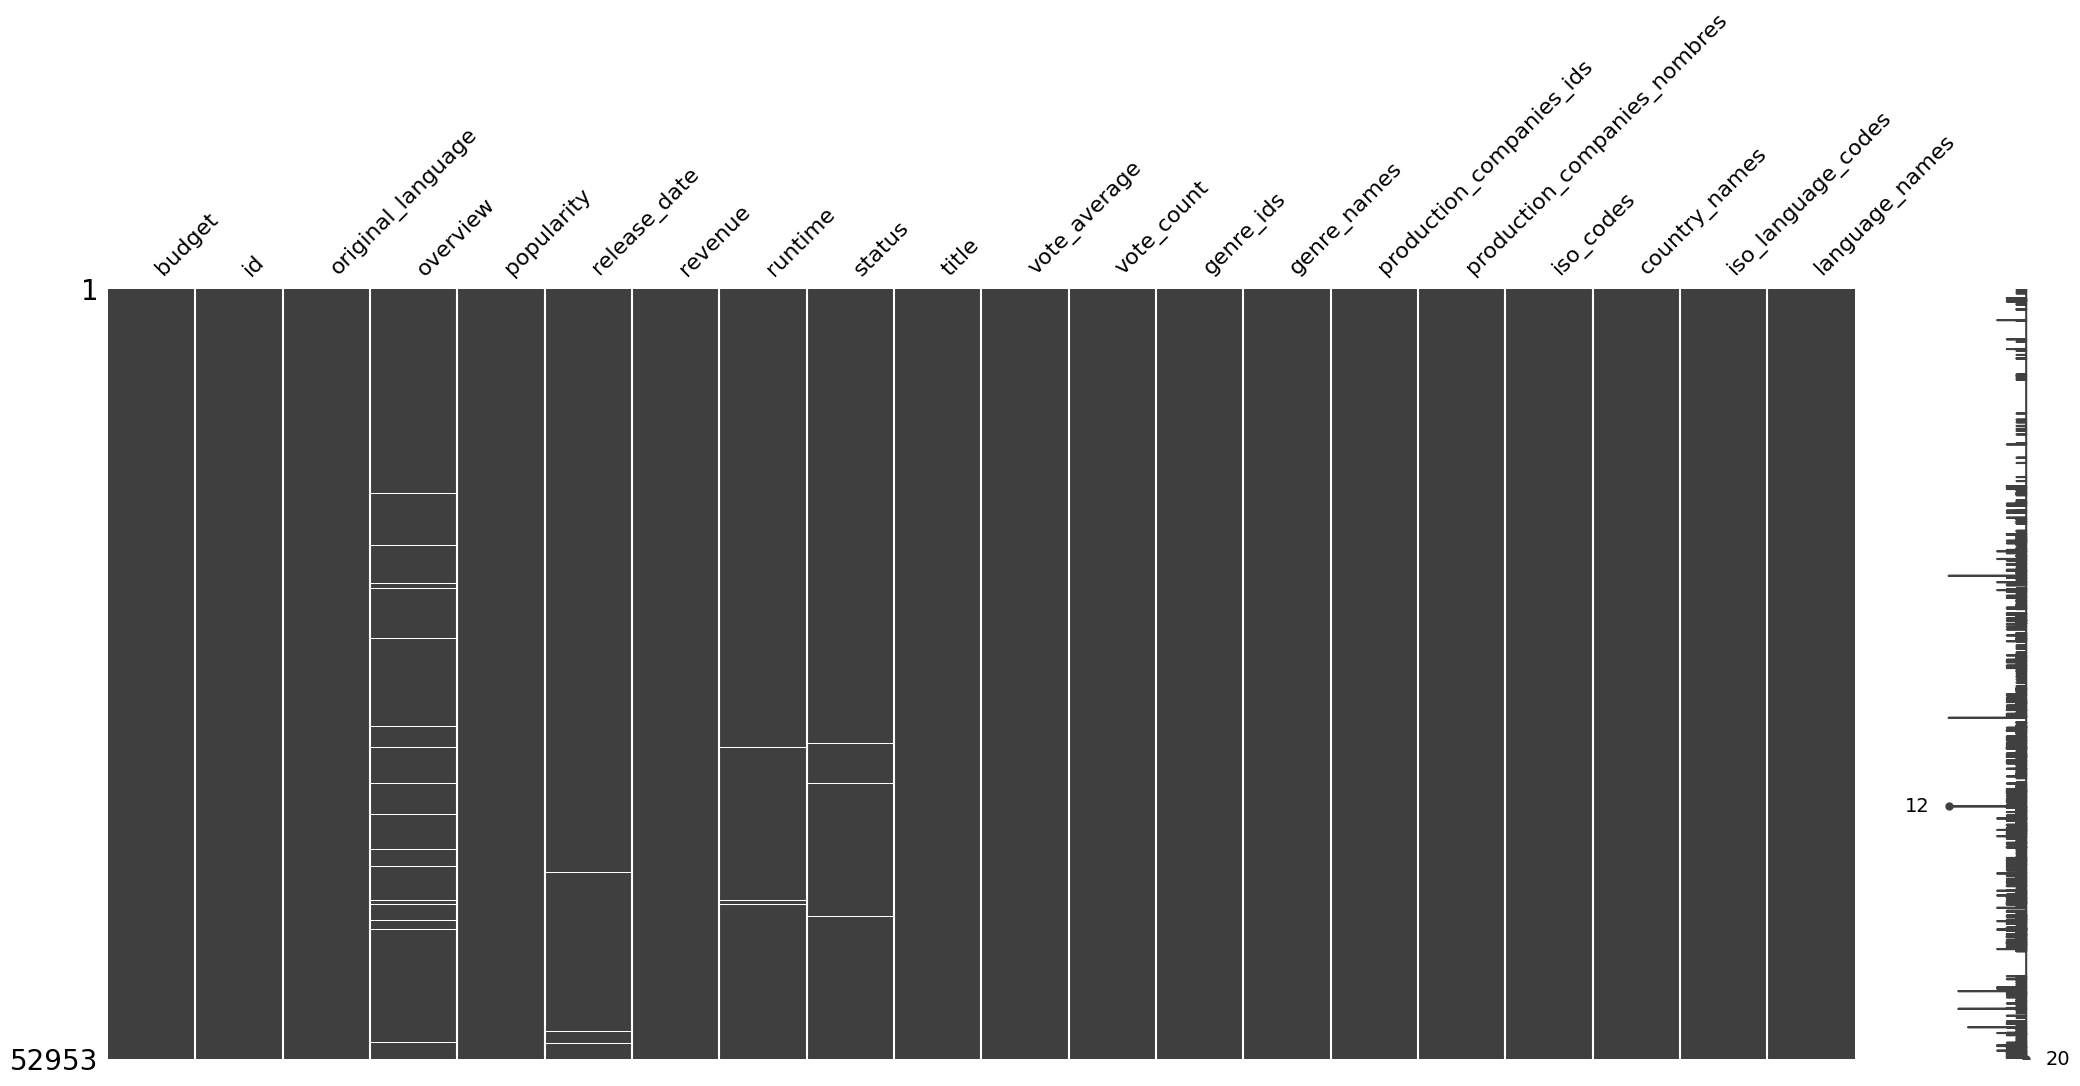

In [125]:
msno.matrix(df_movies)

In [126]:
df_movies.isnull().sum()

budget                             0
id                                 0
original_language                 13
overview                        1079
popularity                         7
release_date                     119
revenue                            9
runtime                          308
status                           106
title                              9
vote_average                       9
vote_count                         9
genre_ids                          0
genre_names                        0
production_companies_ids           0
production_companies_nombres       0
iso_codes                          0
country_names                      0
iso_language_codes                 0
language_names                     0
dtype: int64

### Rescatando algunos valores...

In [127]:
df_movies.loc[:, 'original_language'] = df_movies['original_language'].fillna(df_movies['language_names'])
df_movies.loc[:, 'overview'] = df_movies['overview'].fillna("")
df_movies.loc[:, 'popularity'] = df_movies['popularity'].fillna(0)
df_movies.loc[:, 'release_date'] = df_movies['release_date'].fillna("")
df_movies.loc[:, 'revenue'] = df_movies['revenue'].fillna(0)
df_movies.loc[:, 'runtime'] = df_movies['runtime'].fillna(0)
df_movies.loc[:, 'status'] = df_movies['status'].fillna('Released')
df_movies.loc[:, 'title'] = df_movies['title'].fillna('Unknown')
df_movies.loc[:, 'vote_average'] = df_movies['vote_average'].fillna(0)
df_movies.loc[:, 'vote_count'] = df_movies['vote_count'].fillna(0)

In [128]:
df_movies.isnull().sum()

budget                          0
id                              0
original_language               0
overview                        0
popularity                      0
release_date                    0
revenue                         0
runtime                         0
status                          0
title                           0
vote_average                    0
vote_count                      0
genre_ids                       0
genre_names                     0
production_companies_ids        0
production_companies_nombres    0
iso_codes                       0
country_names                   0
iso_language_codes              0
language_names                  0
dtype: int64

_________________________________________________________

## Some previus Transformations for future dtype assignement...

In [129]:
# Convert all text data to lower case
df_movies = df_movies.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [130]:
df_movies.head(5)

,budget,id,original_language,overview,popularity,release_date,revenue,runtime,status,title,vote_average,vote_count,genre_ids,genre_names,production_companies_ids,production_companies_nombres,iso_codes,country_names,iso_language_codes,language_names
0,30000000,862,en,"led by woody, andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,81.0,released,toy story,7.7,5415.0,"16, 35, 10751","animation, comedy, family",3,pixar animation studios,us,united states of america,en,english
1,65000000,8844,en,when siblings judy and peter discover an encha...,17.015539,1995-12-15,262797249.0,104.0,released,jumanji,6.9,2413.0,"12, 14, 10751","adventure, fantasy, family","559,2550,10201","tristar pictures,teitler film,interscope commu...",us,united states of america,"en,fr","english,français"
2,0,15602,en,a family wedding reignites the ancient feud be...,11.7129,1995-12-22,0.0,101.0,released,grumpier old men,6.5,92.0,"10749, 35","romance, comedy","6194,19464","warner bros.,lancaster gate",us,united states of america,en,english
3,16000000,31357,en,"cheated on, mistreated and stepped on, the wom...",3.859495,1995-12-22,81452156.0,127.0,released,waiting to exhale,6.1,34.0,"35, 18, 10749","comedy, drama, romance",306,twentieth century fox film corporation,us,united states of america,en,english
4,0,11862,en,just when george banks has recovered from his ...,8.387519,1995-02-10,76578911.0,106.0,released,father of the bride part ii,5.7,173.0,35,comedy,"5842,9195","sandollar productions,touchstone pictures",us,united states of america,en,english


In [131]:
# Convert 'budget' column to float, replacing non-numeric values with NaN
df_movies['budget'] = pd.to_numeric(df_movies['budget'], errors='coerce')
df_movies.loc[:, 'budget'] = df_movies['budget'].fillna(0)

<Axes: ylabel='budget'>

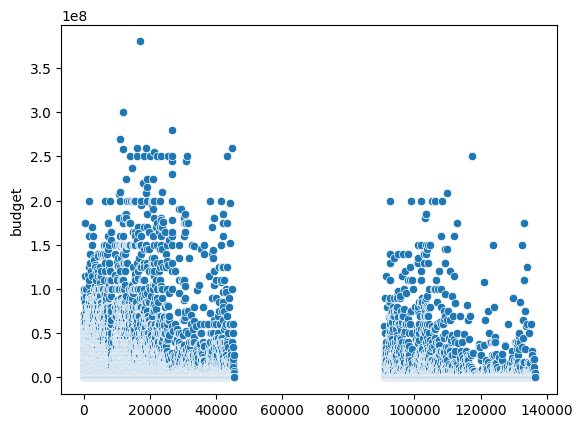

In [132]:
sns.scatterplot(df_movies['budget'])

### To Numeric...

In [133]:
list_column = ['id','popularity','revenue','runtime','vote_average','vote_count']
for column in list_column:
    # Assuming df_movies is your DataFrame
    df_movies[column] = pd.to_numeric(df_movies[column], errors='coerce')

    # Count the number of errors (non-numeric values) in the 'revenue' column
    num_errors = df_movies[column].isna().sum()

    if num_errors > 0:
        df_movies[column] = df_movies[column].fillna(0)

    print(f"Number of errors during coercion {column}: {num_errors}")


Number of errors during coercion id: 6
Number of errors during coercion popularity: 2
Number of errors during coercion revenue: 0
Number of errors during coercion runtime: 0
Number of errors during coercion vote_average: 0
Number of errors during coercion vote_count: 0


In [134]:
# Assuming df_movies is your DataFrame
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'], format='%Y-%m-%d', errors='coerce')

# Count the number of errors (non-numeric values) in the 'revenue' column
num_errors = df_movies['revenue'].isna().sum()

print(f"Number of errors during coercion: {num_errors}")


Number of errors during coercion: 0


## Asignacion de tipos de dato:

In [136]:
# Especificar los tipos de dato para cada columna
data_types = {
    'budget': int,
    'id': int,
    'original_language': str,
    'overview': str,
    'popularity': float,
    'release_date': 'datetime64[ns]',
    'revenue': int,
    'runtime': int,
    'status': str,
    'title': str,
    'vote_average': float,
    'vote_count': int,
    'genre_ids': str,
    'genre_names': str,
    'production_companies_ids': str,
    'production_companies_nombres': str,
    'iso_codes': str,
    'country_names': str,
    'iso_language_codes': str,
    'language_names': str
}

# Asignar los tipos de dato al DataFrame
df_movies = df_movies.astype(data_types)

# Imprimir el DataFrame con los tipos de dato actualizados
print(df_movies.dtypes)

budget                                   int32
id                                       int32
original_language                       object
overview                                object
popularity                             float64
release_date                    datetime64[ns]
revenue                                  int32
runtime                                  int32
status                                  object
title                                   object
vote_average                           float64
vote_count                               int32
genre_ids                               object
genre_names                             object
production_companies_ids                object
production_companies_nombres            object
iso_codes                               object
country_names                           object
iso_language_codes                      object
language_names                          object
dtype: object


## Continuará....